<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>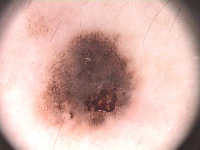</td><td>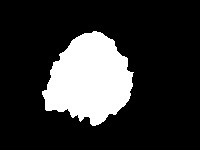</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Так как ссылка была не рабочая, я нашел архив и разархивировал своими руками

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from tqdm import tqdm, notebook
from torch.utils.data import DataLoader
from torch import Tensor

import copy
import numpy as np
import pandas as pd

from matplotlib import rcParams
import seaborn as sns
sns.set_style('darkgrid')
rcParams['figure.figsize'] = (15,4)

In [2]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = '../input/seg-dataset-by-dlschool/'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

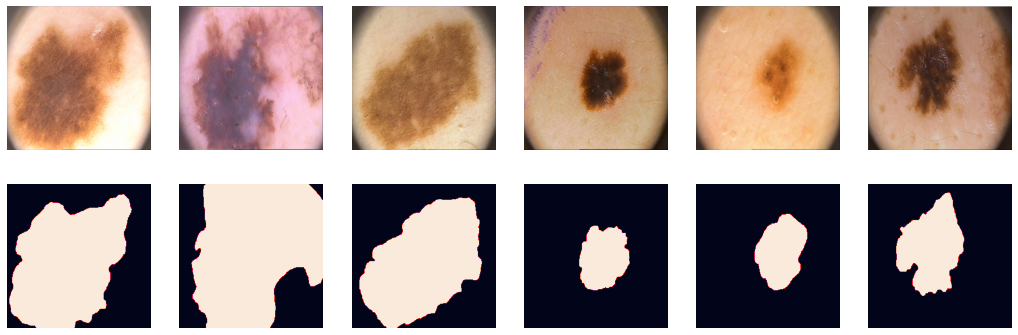

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

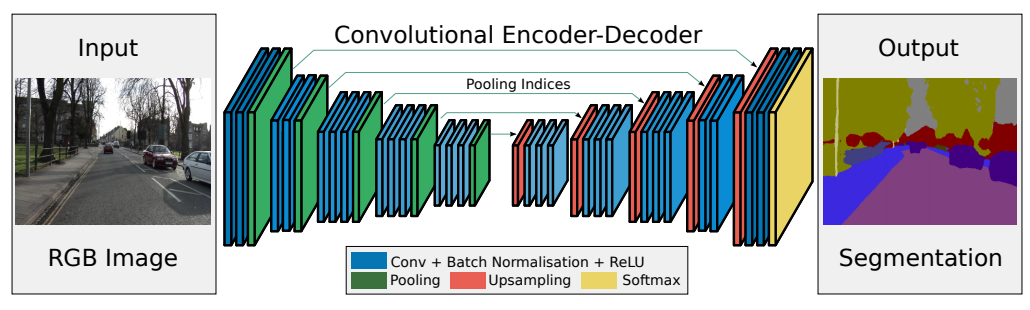

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [12]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        batchNorm_momentum = 0.1

        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv53d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv43d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv33d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv31d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv22d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv11d = nn.Conv2d(64, 1, kernel_size=3, padding=1)


    def forward(self, x):

        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x)))
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1p, id1 = F.max_pool2d(x12,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2p, id2 = F.max_pool2d(x22,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x33 = F.relu(self.bn33(self.conv33(x32)))
        x3p, id3 = F.max_pool2d(x33,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = F.relu(self.bn42(self.conv42(x41)))
        x43 = F.relu(self.bn43(self.conv43(x42)))
        x4p, id4 = F.max_pool2d(x43,kernel_size=2, stride=2,return_indices=True)

        # Stage 5
        x51 = F.relu(self.bn51(self.conv51(x4p)))
        x52 = F.relu(self.bn52(self.conv52(x51)))
        x53 = F.relu(self.bn53(self.conv53(x52)))
        x5p, id5 = F.max_pool2d(x53,kernel_size=2, stride=2,return_indices=True)


        # Stage 5d
        x5d = F.max_unpool2d(x5p, id5, kernel_size=2, stride=2)
        x53d = F.relu(self.bn53d(self.conv53d(x5d)))
        x52d = F.relu(self.bn52d(self.conv52d(x53d)))
        x51d = F.relu(self.bn51d(self.conv51d(x52d)))

        # Stage 4d
        x4d = F.max_unpool2d(x51d, id4, kernel_size=2, stride=2)
        x43d = F.relu(self.bn43d(self.conv43d(x4d)))
        x42d = F.relu(self.bn42d(self.conv42d(x43d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))

        # Stage 3d
        x3d = F.max_unpool2d(x41d, id3, kernel_size=2, stride=2)
        x33d = F.relu(self.bn33d(self.conv33d(x3d)))
        x32d = F.relu(self.bn32d(self.conv32d(x33d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))

        # Stage 2d
        x2d = F.max_unpool2d(x31d, id2, kernel_size=2, stride=2)
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        x1d = F.max_unpool2d(x21d, id1, kernel_size=2, stride=2)
        x12d = F.relu(self.bn12d(self.conv12d(x1d)))
        x11d = self.conv11d(x12d)

        return x11d

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [13]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [14]:
def bce_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [15]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler = 'None', filename = 'None'):
    train_loss = []
    val_loss = []
    scores = []
    test_scores = []
    best_score = 0 
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        avg_val_loss = 0
        score = 0
        model.train()  # train mode
        for X_batch, Y_batch in tqdm(data_tr):
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            model.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            scheduler.step()
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss.item())
        
        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
            for X_val, Y_val in tqdm(data_val):
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)
                Y_hat = model(X_val)
                loss = loss_fn(Y_val, Y_hat)
                avg_val_loss = loss/len(data_val)
                # Get score
                Y_score = (torch.sigmoid(Y_hat) >= 0.5)
                score += iou_pytorch(Y_score, Y_val).mean().item()
        val_loss.append(avg_val_loss.item())
        print(f'Val loss: {val_loss[-1]}')
        scores.append(score/len(data_val))
        print(f'Score: {scores[-1]}')
        X_val, Y_val, Y_hat = X_val.cpu(), Y_val.cpu(), Y_hat.detach().cpu()
        
        # Сохранение лучшей модели
        if filename is not 'None':
            if best_score < scores[-1]:
                best_score = scores[-1]
                best_weights = copy.deepcopy(model.state_dict())
                torch.save(best_weights, filename)
            
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
    # Загружаем веса по лучшему скору 
    if filename is not 'None':
        model.state_dict = torch.load(filename)
    
    # Отрисовка итоговых результатов
    plt.plot(train_loss, label = 'train')
    plt.plot(val_loss, label = 'val')
    plt.legend()
    plt.show()
    plt.plot(scores, label = 'val_score')
    plt.legend()
    plt.show()
    
    return val_loss, scores

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [16]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [17]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
            Y_pred = model(X_batch)
            Y_pred = (torch.sigmoid(Y_pred) >= 0.5)
            scores += metric(Y_pred, Y_label).mean().item()
    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


Я счет целесообразным ловить переобучение по скору, так как на валидационной выборке очень мало данных, и она не может показать всю картину. Далее из результатов тестирования это можно заметить.

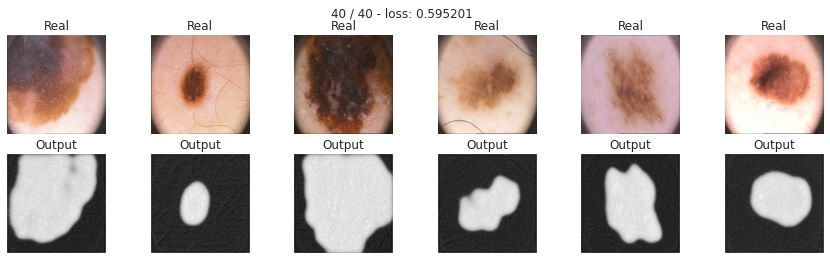

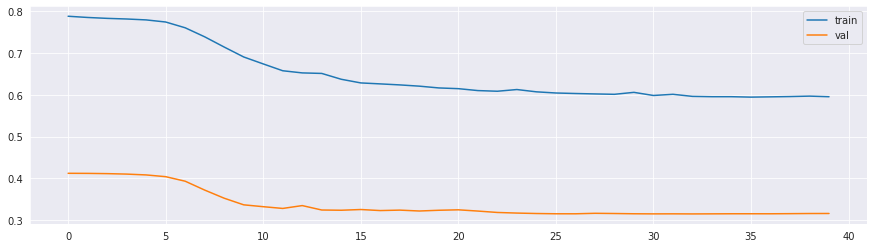

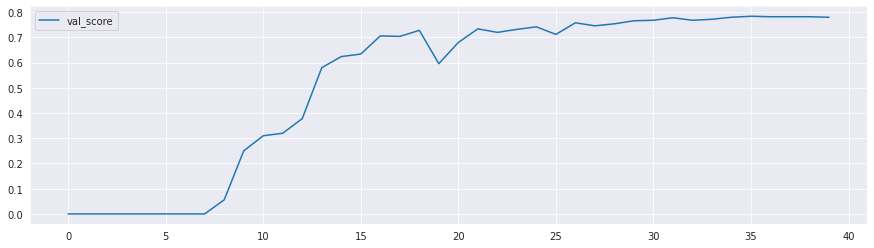

In [18]:
model = SegNet().to(device)
max_epochs = 40
optimazer = optim.Adam(model.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimazer, 1e-4, steps_per_epoch=len(data_tr), epochs=max_epochs)
bce_segnet_loss, bce_segnet_score = train(model, optimazer, bce_loss, max_epochs, data_tr, data_val, scheduler, 'segnet.pth')
test_bce_segnet_score = score_model(model, iou_pytorch, data_ts)

Ответьте себе на вопрос: не переобучается ли моя модель?

Да, модель переобучается, если обучить ее на 40 эпохах. Если судить про графику лосса на валидации, то можно сказать что модель переобучилась на 15 эпохе, но по графику скора я бы сказал, что переобучение наступило после 30 эпох, хотя впоть до 40 эпох скор стабильно рос.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [19]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum()
    dsc = (2. * intersection + smooth) / (union + smooth)
    return 1. - dsc

Проводим тестирование:

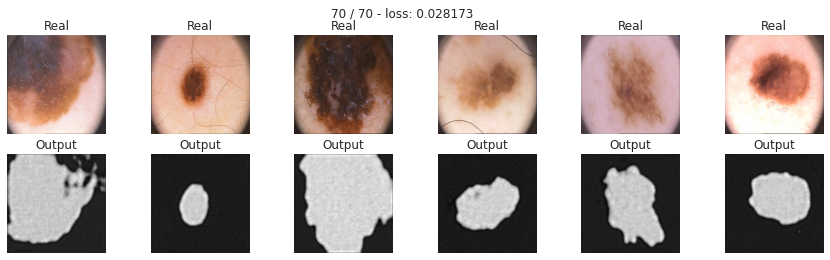

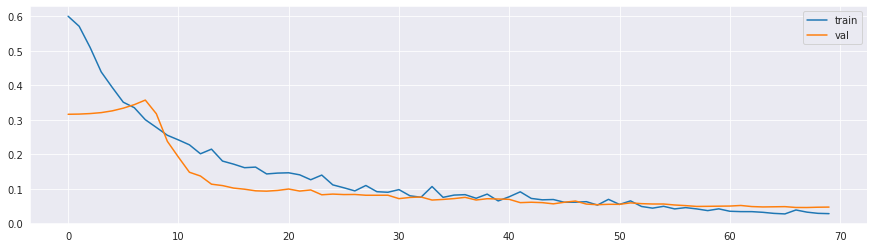

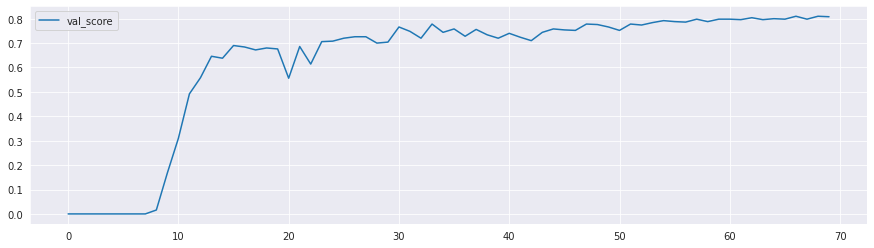

In [59]:
model = SegNet().to(device)
max_epochs = 60
optimaizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimazer, 1e-4, steps_per_epoch=len(data_tr), epochs=max_epochs)
dice_segnet_loss, dice_segnet_score = train(model, optimaizer, dice_loss, 
                                            max_epochs, data_tr, data_val, scheduler, 'segnet.pth')
test_dice_segnet_score = score_model(model, iou_pytorch, data_ts)

In [60]:
test_dice_segnet_score

0.6919999718666077

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [21]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred =  torch.sigmoid(y_pred)
    y_pred = torch.clamp(y_pred, min=0.1, max=0.9)
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    FL = -((1 - y_pred)**gamma*y_real*y_pred.log() + (1 - y_real)*(1 - y_pred).log())
    return FL.mean()


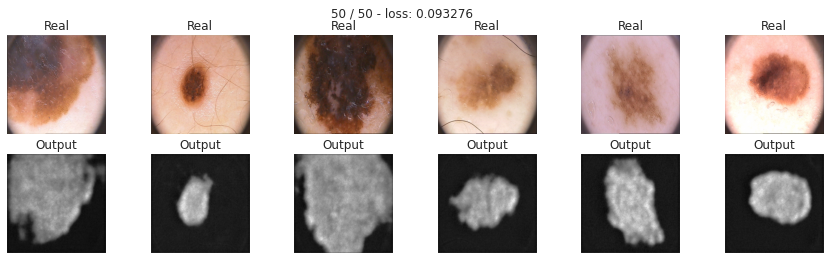

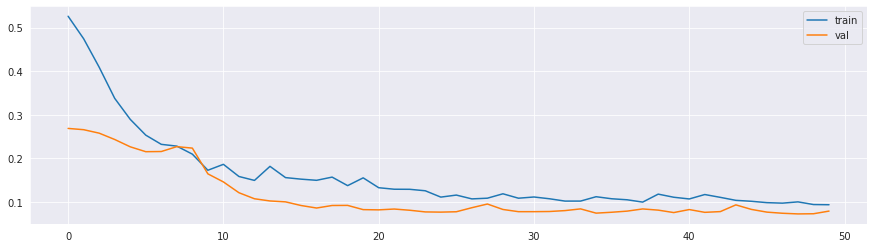

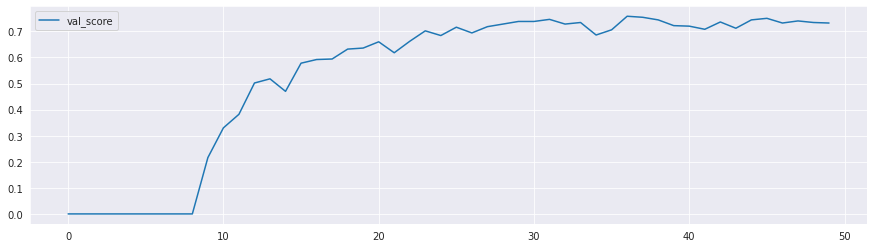

In [61]:
model = SegNet().to(device)
max_epochs = 50
optimaizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimazer, 1e-4, steps_per_epoch=len(data_tr), epochs=max_epochs)
focal_segnet_loss, focal_segnet_score = train(model, optimaizer, focal_loss, 
                                              max_epochs, data_tr, data_val,scheduler, 'segnet.pth')
test_focal_segnet_score = score_model(model, iou_pytorch, data_ts)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [24]:
from scipy.ndimage import distance_transform_edt as distance
from torch import einsum

def probs2class(probs: Tensor) -> Tensor:
    res = (probs >= 0.5).type(torch.float16)
    return res

def get_dist(y_real: np.ndarray) -> np.ndarray:
    C: int = len(y_real)
    res = np.zeros_like(y_real)
    for c in range(C):
        posmask = y_real[c].astype(np.bool)

        if posmask.any():
            negmask = ~posmask
            #print('negmask:', negmask)
            #print('distance(negmask):', distance(negmask))
            res[c] = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
            #print('res[c]', res[c])
    return Tensor(res).to(device)

def boundary_loss(y_real: Tensor, y_pred: Tensor) -> Tensor:
    y_pred = torch.sigmoid(y_pred)
    dist_map = get_dist(y_real.cpu().numpy())
    pred_class = probs2class(y_pred)
    multipled = einsum("bcwh,bcwh->bcwh", y_pred, dist_map) # Покомпонентное переумножение

    loss = multipled.mean()

    return loss

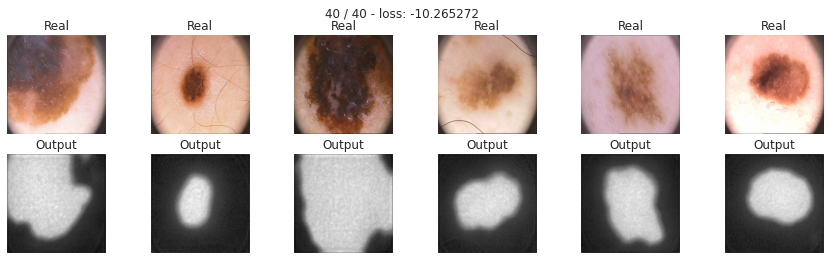

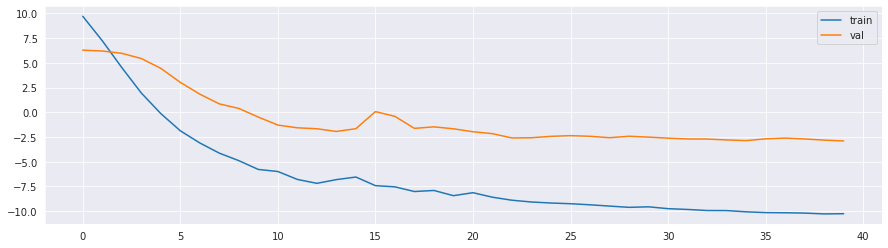

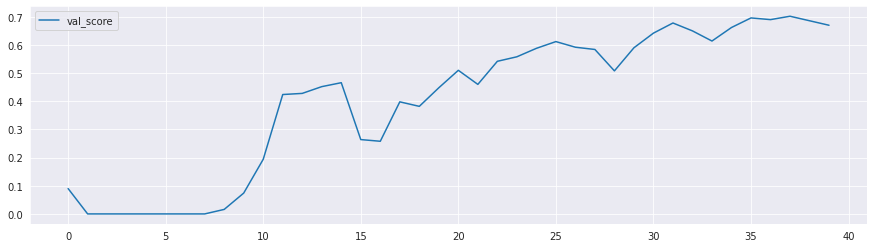

In [25]:
model = SegNet().to(device)
max_epochs = 40
optimaizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimazer, 1e-4, steps_per_epoch=len(data_tr), epochs=max_epochs)
bound_segnet_loss, bound_segnet_score = train(model, optimaizer, boundary_loss, 
                                              max_epochs, data_tr, data_val, scheduler, 'segnet.pth')
test_boundary_segnet_score = score_model(model, iou_pytorch, data_ts)

Boundary loss предназначен для сегментирования очень маленьких обьектов, и как я понял из реализации, 
на лосс сильно влияет определение центра сегментированного обьекта, поэтому он очень хорошо определяет центр, но размывает края. Если бы все наши обьекты были маленькими, то он бы показал себя намного лучше, но у нас есть как несбалансированные, так и очень большие изображения.

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

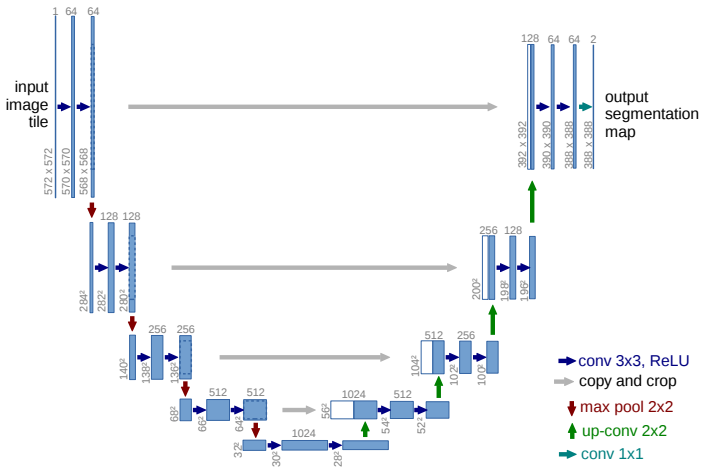

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [26]:
def double_conv(in_, out_):
    return nn.Sequential(
        nn.Conv2d(in_, out_, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_),
        nn.Conv2d(out_, out_, 3, padding=1),
        nn.BatchNorm2d(out_),
        nn.ReLU()
    )   

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)      

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv(512 + 1024, 512)
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, 1, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)
        
        conv5 = self.dconv_down5(x)

        x = torch.cat([x, conv5], dim=1)
        x = self.upsample(x)  
        x = self.dconv_up4(x)


        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out
    

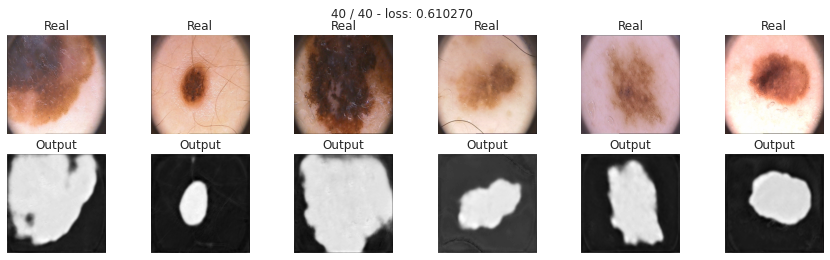

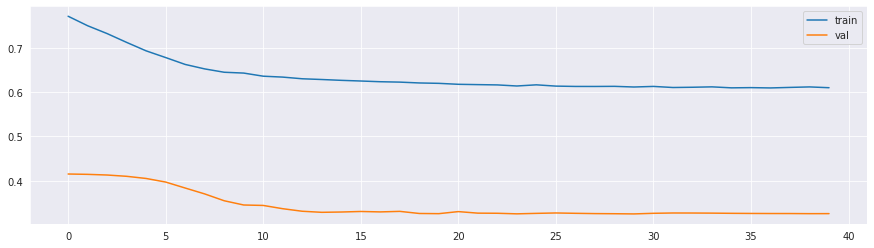

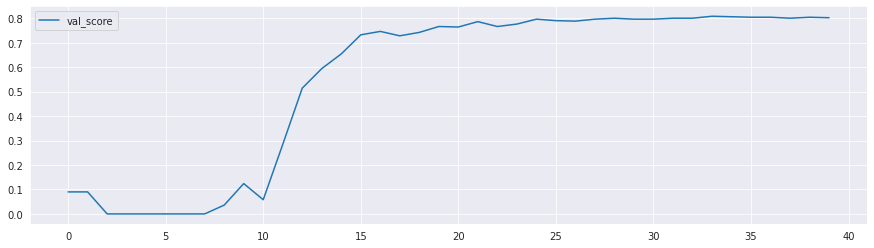

In [27]:
unet_model = UNet().to(device)
max_epoch = 40
optimazer = optim.Adam(unet_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimazer, 1e-4, steps_per_epoch=len(data_tr), epochs=max_epoch)
bce_unet_loss, bce_unet_score = train(unet_model, optimazer, bce_loss, max_epoch, data_tr, data_val, scheduler, 'unet.pht')
test_bce_unet_score = score_model(unet_model, iou_pytorch, data_ts)

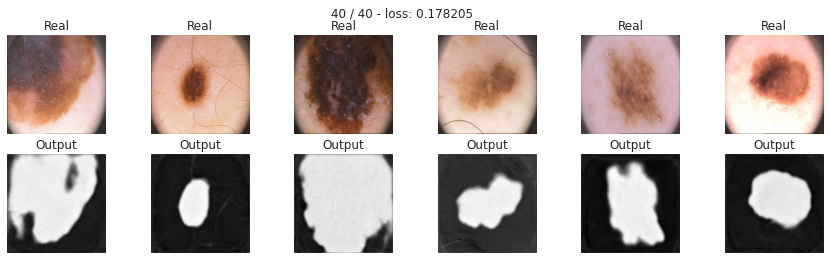

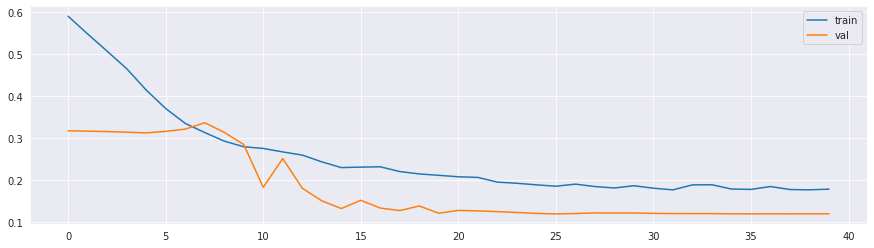

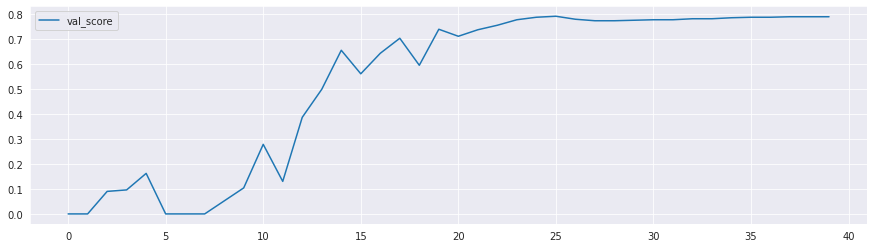

In [28]:
unet_model = UNet().to(device)
max_epoch = 40
optimazer = optim.Adam(unet_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimazer, 1e-4, steps_per_epoch=len(data_tr), epochs=max_epoch)
dice_unet_loss, dice_unet_score = train(unet_model, optimazer,dice_loss, max_epoch, data_tr, data_val, scheduler, 'unet.pht')
test_dice_unet_score = score_model(unet_model, iou_pytorch, data_ts)

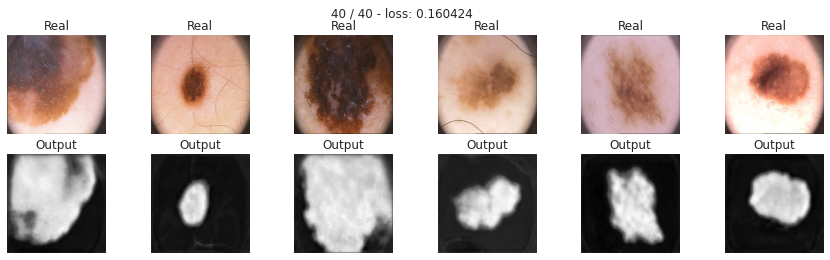

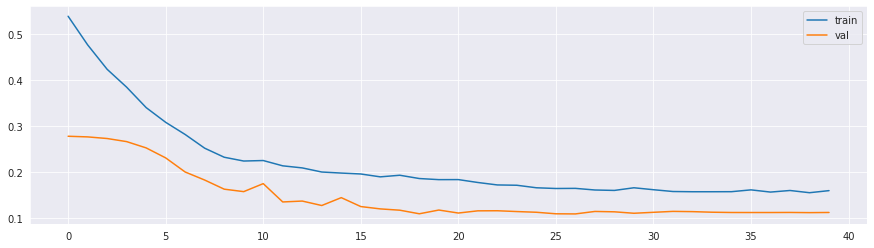

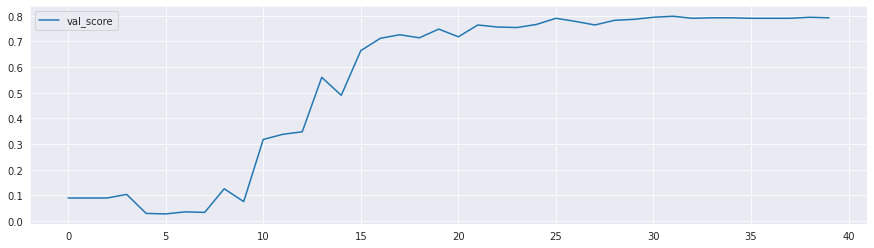

In [29]:
unet_model = UNet().to(device)
max_epoch = 40
optimazer = optim.Adam(unet_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimazer, 1e-4, steps_per_epoch=len(data_tr), epochs=max_epoch)
focal_unet_loss, focal_unet_score = train(unet_model, optimazer, focal_loss, max_epoch, data_tr, data_val, scheduler, 'unet.pht')
test_focal_unet_score = score_model(unet_model, iou_pytorch, data_ts)

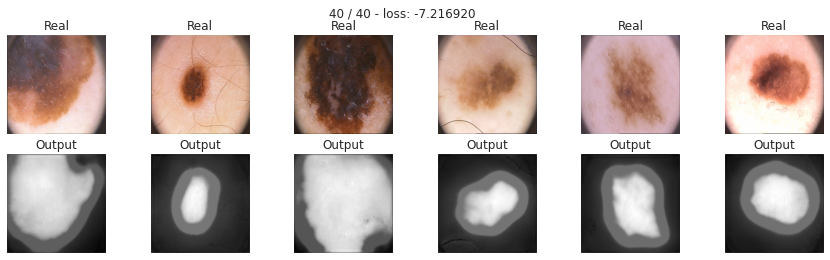

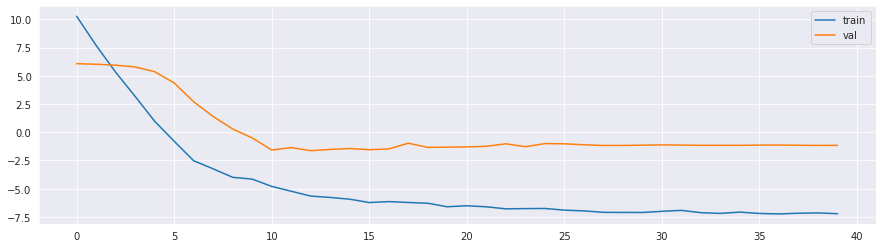

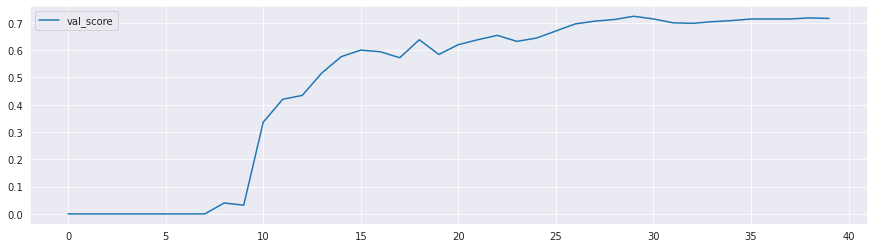

In [30]:
unet_model = UNet().to(device)
max_epoch = 40
optimazer = optim.Adam(unet_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.OneCycleLR(optimazer, 1e-4, steps_per_epoch=len(data_tr), epochs=max_epoch)
bound_unet_loss, bound_unet_score = train(unet_model, optimazer, boundary_loss, max_epoch, data_tr, data_val, scheduler, 'unet.pth')
test_bound_unet_score = score_model(unet_model, iou_pytorch, data_ts)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [31]:
def double_conv(in_, out_):
    return nn.Sequential(
        nn.Conv2d(in_, out_, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_),
        nn.Conv2d(out_, out_, 3, padding=1),
        nn.BatchNorm2d(out_),
        nn.ReLU()
    )  

class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)      

        self.maxpool = nn.MaxPool2d(2)
        self.upsample4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dconv_up4 = double_conv(512 + 1024, 512)

        self.upsample3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv_up3 = double_conv(256 + 512, 256)

        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv_up2 = double_conv(128 + 256, 128)

        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv_last = nn.Conv2d(64, 1, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)  

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        conv5 = self.dconv_down5(x)
        x = self.maxpool(conv5)

        x = self.upsample4(x)
        x = torch.cat((x, conv5), dim=1)
        x = self.dconv_up4(x)
        
        x = self.upsample3(x)
        x = torch.cat((x, conv4), dim=1)
        x = self.dconv_up3(x)

        x = self.upsample2(x)
        x = torch.cat((x, conv3), dim=1)
        x = self.dconv_up2(x)

        x = self.upsample1(x)
        x = torch.cat((x, conv2), dim=1)   
        x = self.dconv_up1(x)
        
        x = self.upsample0(x)
        out = self.conv_last(x)
        
        return out


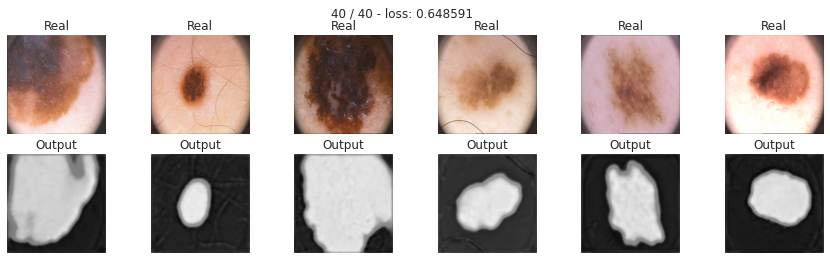

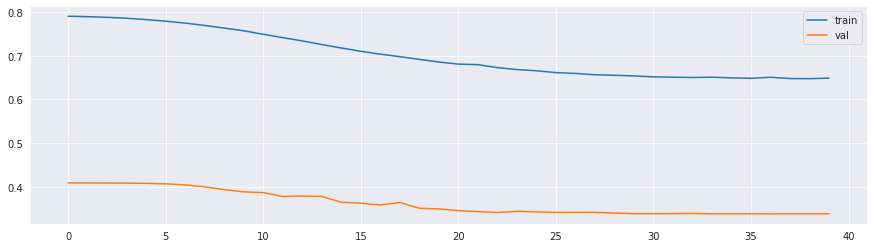

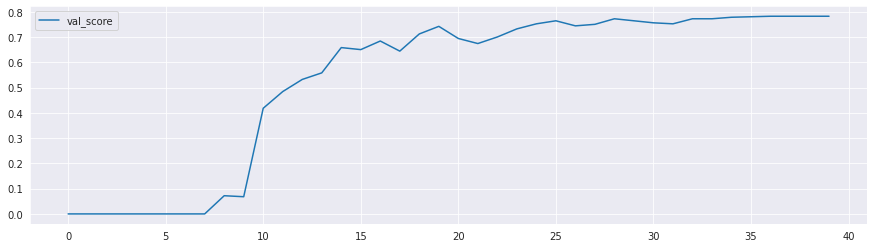

In [33]:
unet2_model = UNet2().to(device)
max_epoch = 40
optimazer = optim.Adam(unet2_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimazer, 1e-4, steps_per_epoch=len(data_tr), epochs=max_epoch)
bce_unet2_loss, bce_unet2_score = train(unet2_model, optimazer, bce_loss, max_epoch, data_tr, data_val, scheduler, 'unet2.pth')
test_bce_unet2_score = score_model(unet2_model, iou_pytorch, data_ts)

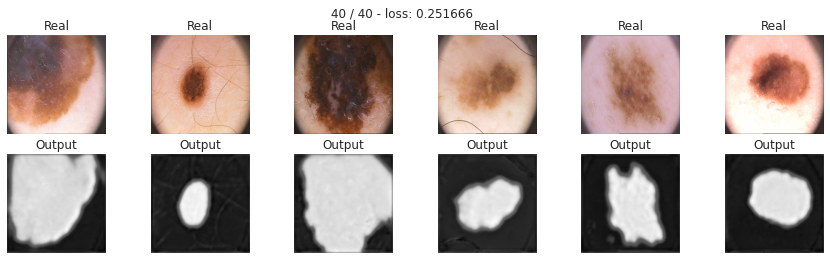

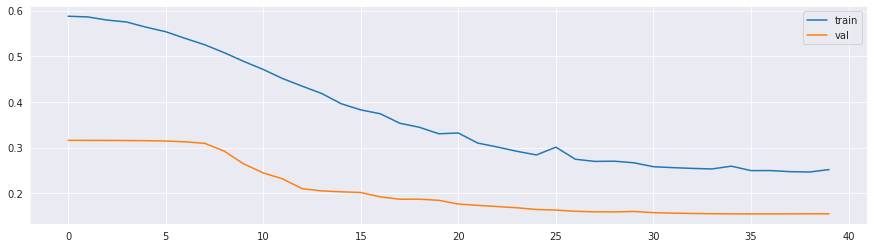

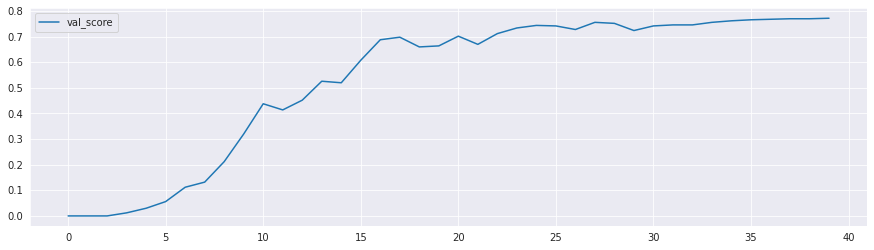

In [35]:
unet2_model = UNet2().to(device)
max_epoch = 40
optimazer = optim.Adam(unet2_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimazer, 1e-4, steps_per_epoch=len(data_tr), epochs=max_epoch)
dice_unet2_loss, dice_unet2_score = train(unet2_model, optimazer,dice_loss, max_epoch, data_tr, data_val, scheduler, 'unet2.pth')
test_dice_unet2_score = score_model(unet2_model, iou_pytorch, data_ts)

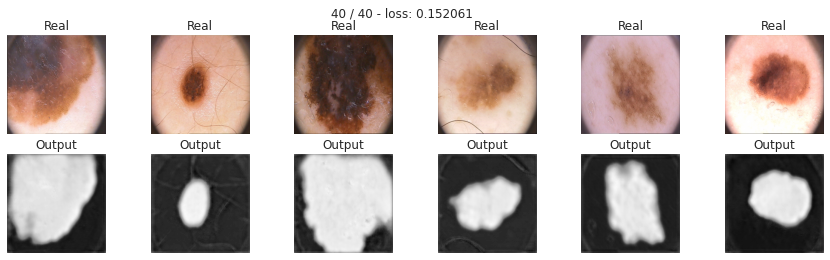

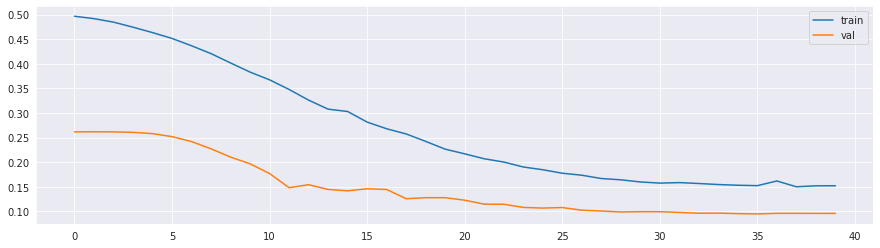

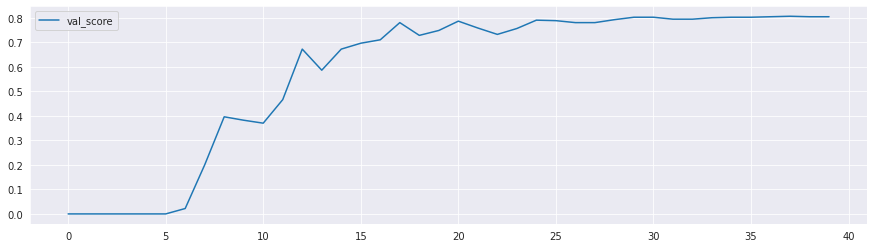

In [36]:
unet2_model = UNet2().to(device)
max_epoch = 40
optimazer = optim.Adam(unet2_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimazer, 1e-4, steps_per_epoch=len(data_tr), epochs=max_epoch)
focal_unet2_loss, facal_unet2_score = train(unet2_model, optimazer,focal_loss, max_epoch, data_tr, data_val, scheduler, 'unet2.pth')
test_focal_unet2_score = score_model(unet2_model, iou_pytorch, data_ts)

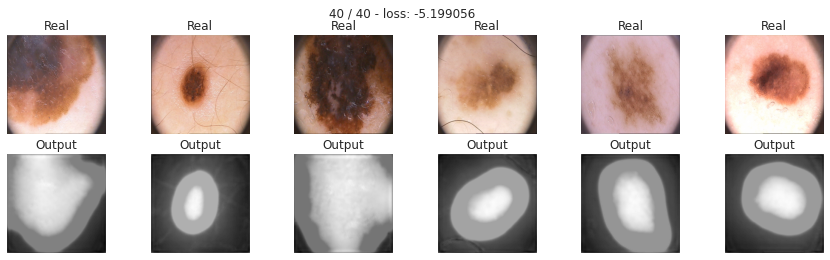

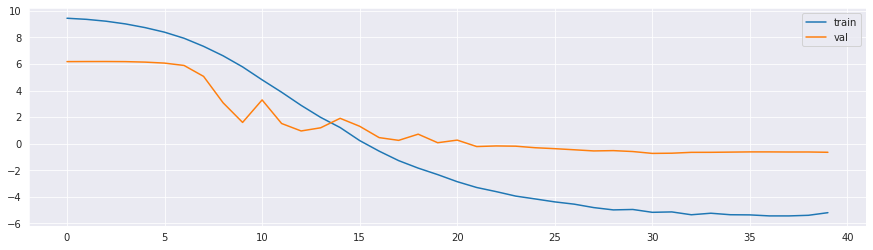

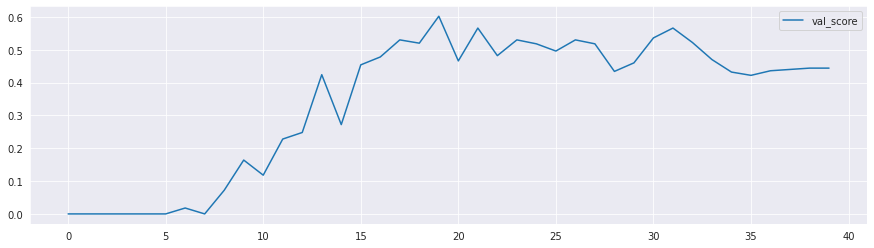

In [37]:
unet2_model = UNet2().to(device)
max_epoch = 40
optimazer = optim.Adam(unet2_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimazer, 1e-4, steps_per_epoch=len(data_tr), epochs=max_epoch)
bound_unet2_loss, bound_unet2_score = train(unet2_model, optimazer, boundary_loss, max_epoch, data_tr, data_val, scheduler, 'unet2.pth')
test_bound_unet2_score = score_model(unet2_model, iou_pytorch, data_ts)

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

In [57]:
def show_losses_by_model(results):
    plt.figure(figsize=(12, 8))
    plt.plot(results[0])
    plt.title('bce_loss')
    plt.show()
    plt.plot(results[1])
    plt.title('dice_loss')
    plt.show()
    plt.plot(results[2])
    plt.title('focal_loss')
    plt.show()
    plt.plot(results[3])
    plt.title('boundary_loss')
    plt.show()
    
    plt.plot(results[0], label = 'bce_loss')
    plt.plot(results[1], label = 'dice_loss')
    plt.plot(results[2], label = 'focal_loss')
    plt.legend()
    plt.title('All_loss_func')
    plt.show()

In [41]:
def show_scores_by_model(results):
    plt.figure(figsize=(12, 8))
    plt.plot(results[0], label = 'bce_loss')
    plt.plot(results[1], label = 'dice_loss')
    plt.plot(results[2], label = 'focal_loss')
    plt.plot(results[3], label = 'boundary_loss')
    plt.legend()
    plt.title('Score_loss_func')
    plt.show()

### SegNet

In [42]:
segnet_losses = [bce_segnet_loss, dice_segnet_loss, focal_segnet_loss, bound_segnet_loss]
segnet_scores = [bce_segnet_score, dice_segnet_score, focal_segnet_score, bound_segnet_score]

Посмотрим на графики лосса

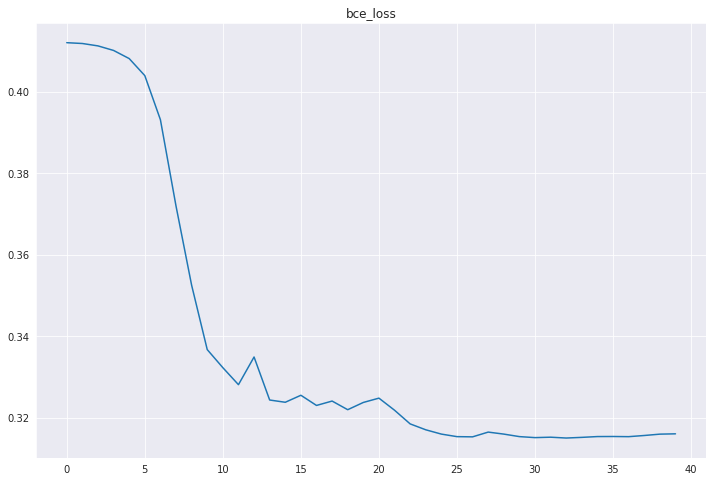

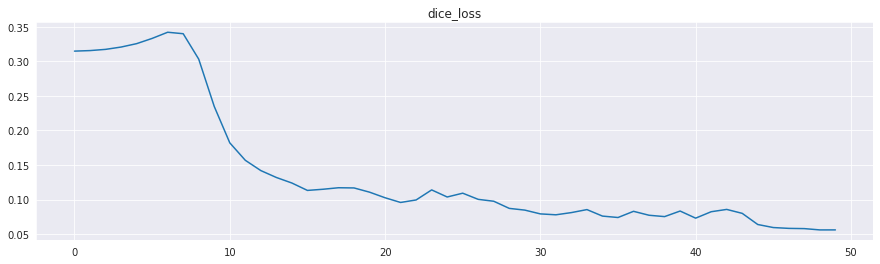

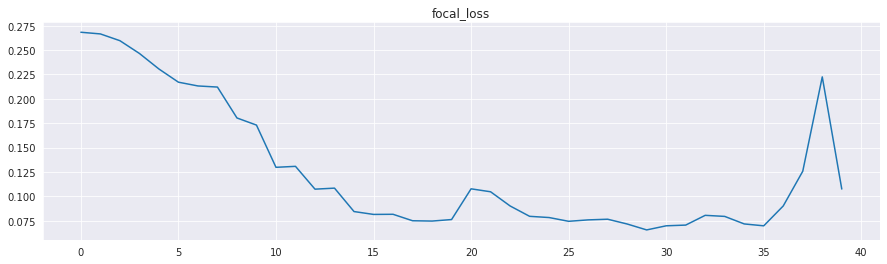

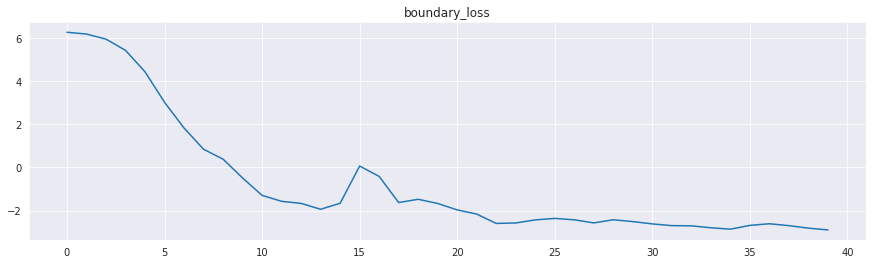

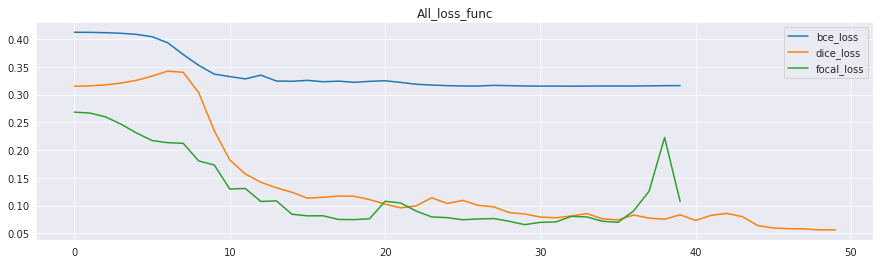

In [58]:
show_losses_by_model(segnet_losses)

Так как boundary loss у нас не находится в пространстве (0,1), то на совместном графике его отобразить не получилось.

**Вывод**:  

*bce_loss* выглядит переобученным, хотя уже было показано что это не так сильно выраженно  
*dice_loss* уменьшался до последней эпох  
*focal_loss* повел себя довольно нестабильно на последних эпохах.Возможно он выбрался из локального минимума.  
*boundary_loss* практически не изменяется на последних эпохах, но скор увеличивался до последней итерации

Теперь посмотрим на показатели скора на валидации

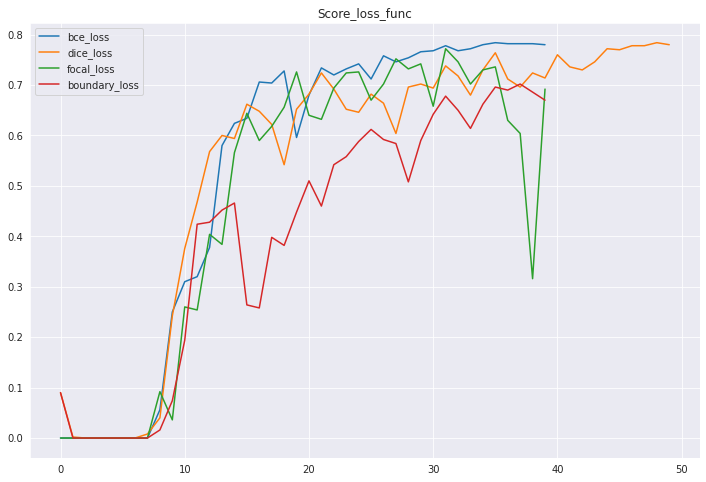

In [46]:
show_scores_by_model(segnet_scores)

Теперь время для статистики на тестовом датасете

In [48]:
test_scores = [test_bce_segnet_score, test_dice_segnet_score, test_focal_segnet_score, test_boundary_segnet_score]
segnet_results = pd.DataFrame(data = {
    'Loss function': ['bce_loss', 'dice_loss', 'focal_loss', 'boundary_loss'],
    'Score on test': test_scores
})
segnet_results

Loss function  Score on test
0       bce_loss          0.656
1      dice_loss          0.694
2     focal_loss          0.622
3  boundary_loss          0.568

**Вывод**:

Лучше всего показал себя dice_loss, хотя на валидационной выборке bce_loss показал примерно такой же скор. Boundary_loss хуже всех, возможно из-за того что он расчитан на изображения с большим дисбалансом. 

### Unet1

In [66]:
unet_losses = [bce_unet_loss, dice_unet_loss, focal_unet_loss, bound_unet_loss]
unet_scores = [bce_unet_score, dice_unet_score, facal_unet_score, bound_unet_score]

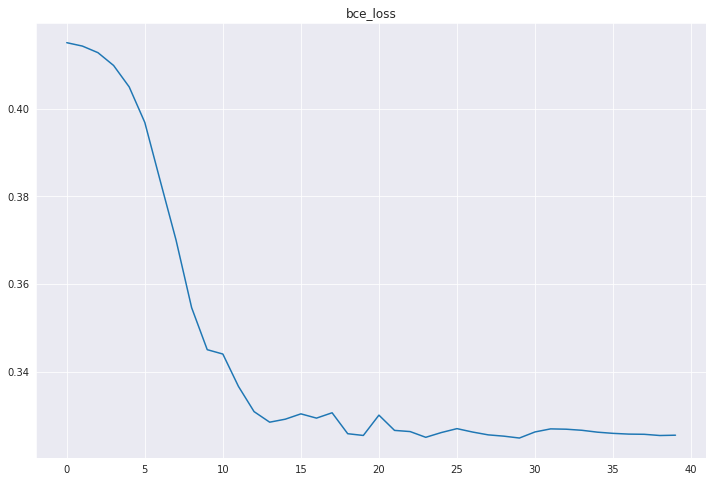

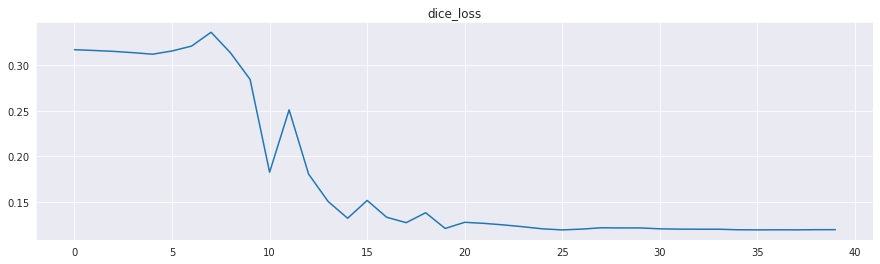

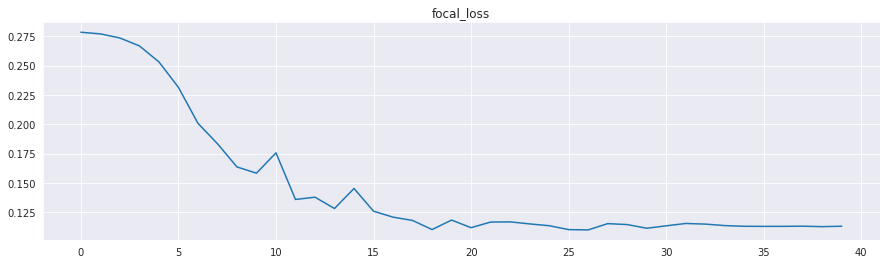

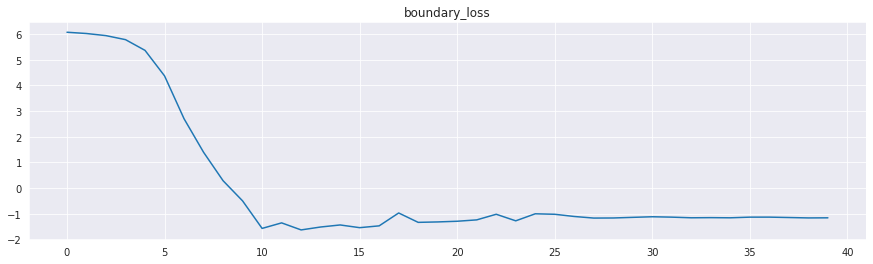

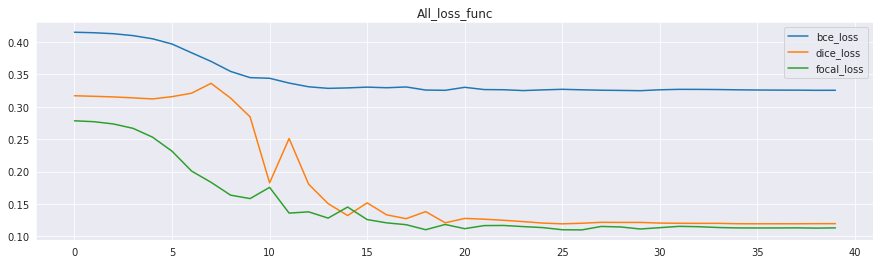

In [67]:
show_losses_by_model(unet_losses)

Все функции переобучаются примерно к 25 эпох, поэтому дальше учить нет смысла

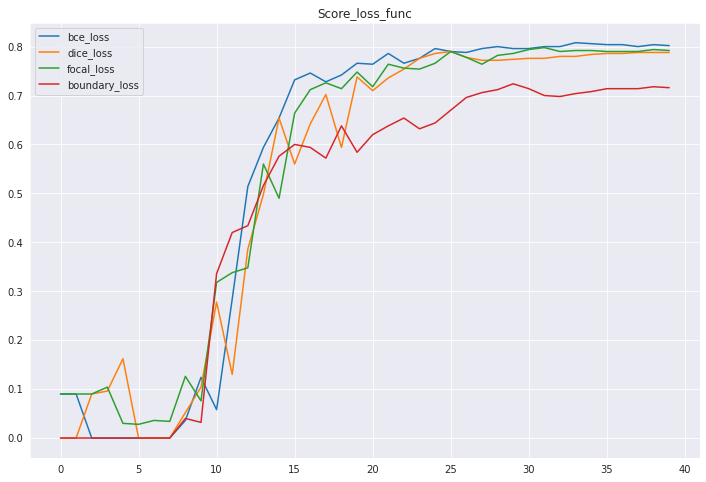

In [68]:
show_scores_by_model(unet_scores)

In [70]:
test_scores = [test_bce_unet_score, test_dice_unet_score, test_focal_unet_score, test_bound_unet_score]
unet_results = pd.DataFrame(data = {
    'Loss function': ['bce_loss', 'dice_loss', 'focal_loss', 'boundary_loss'],
    'Score on test': test_scores
})
unet_results

Loss function  Score on test
0       bce_loss          0.718
1      dice_loss          0.704
2     focal_loss          0.702
3  boundary_loss          0.668

**Вывод**:  

Лучшим теперь показал себя bce_loss, что удивительно, учитывая простоту его реализации и отсутсвие регуляризации. Худшим опять показал себя boundary_loss

### Unet2

In [71]:
unet2_losses = [bce_unet2_loss, dice_unet2_loss, focal_unet2_loss, bound_unet2_loss]
unet2_scores = [bce_unet2_score, dice_unet2_score, facal_unet2_score, bound_unet2_score]

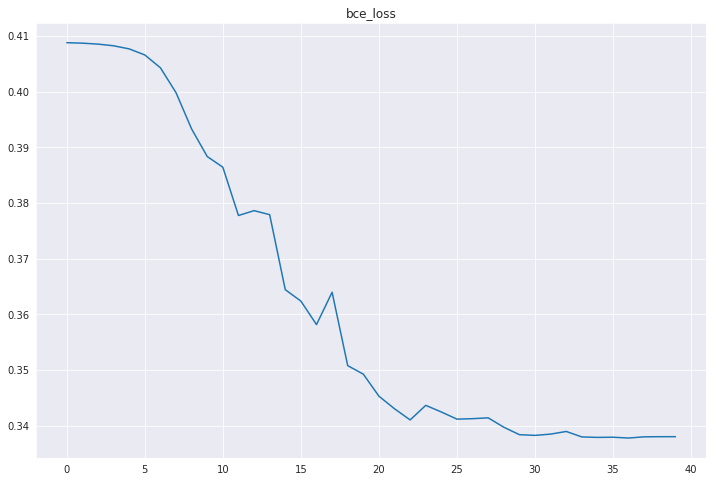

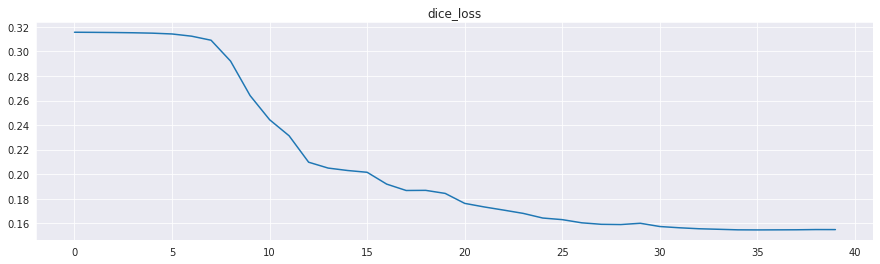

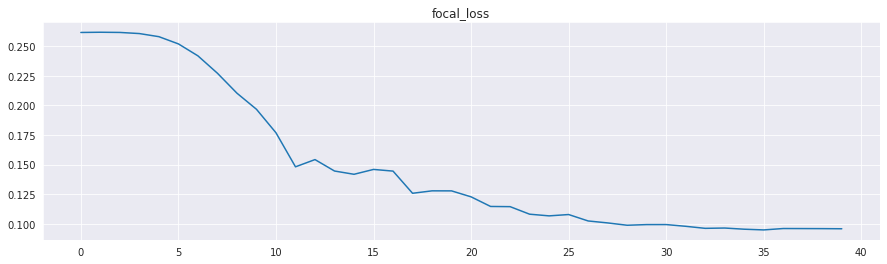

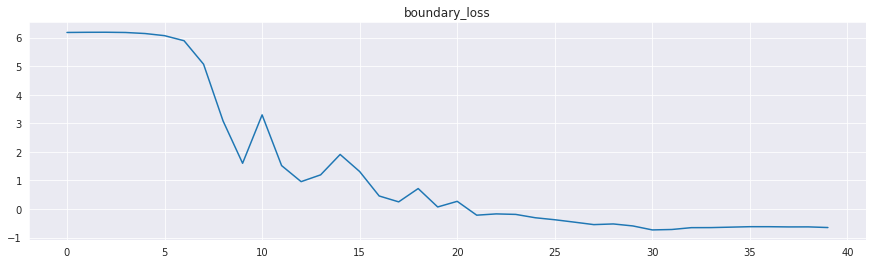

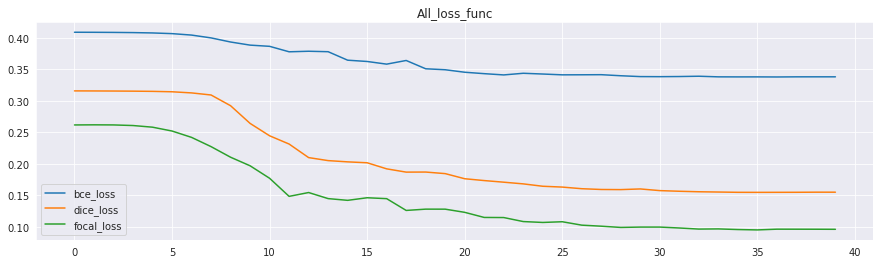

In [72]:
show_losses_by_model(unet2_losses)

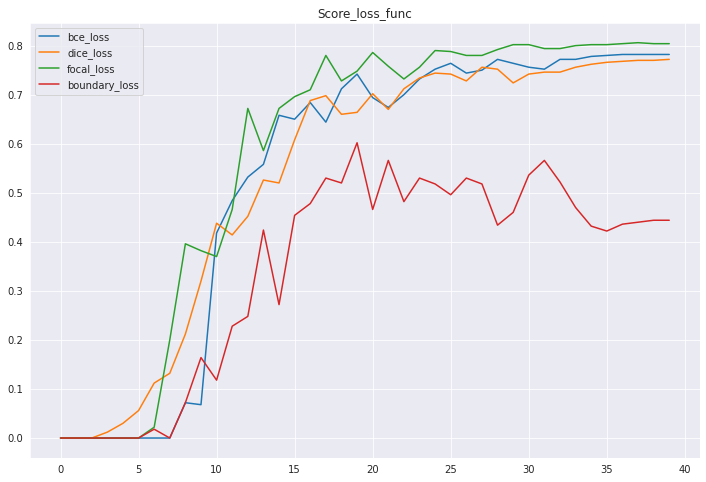

In [73]:
show_scores_by_model(unet2_scores)

In [74]:
test_scores = [test_bce_unet2_score, test_dice_unet2_score, test_focal_unet2_score, test_bound_unet2_score]
unet2_results = pd.DataFrame(data = {
    'Loss function': ['bce_loss', 'dice_loss', 'focal_loss', 'boundary_loss'],
    'Score on test': test_scores
})
unet2_results

Loss function  Score on test
0       bce_loss          0.690
1      dice_loss          0.710
2     focal_loss          0.722
3  boundary_loss          0.376

### Итог по всем моделям

In [93]:
models = ['SegNet']*4 + ['UNet']*4 + ['UNet2']*4
concl = pd.concat([segnet_results, unet_results, unet2_results]).reset_index(drop=True)
concl.insert(0, 'Models', models)
concl

Models  Loss function  Score on test
0   SegNet       bce_loss          0.656
1   SegNet      dice_loss          0.694
2   SegNet     focal_loss          0.622
3   SegNet  boundary_loss          0.568
4     UNet       bce_loss          0.718
5     UNet      dice_loss          0.704
6     UNet     focal_loss          0.702
7     UNet  boundary_loss          0.668
8    UNet2       bce_loss          0.690
9    UNet2      dice_loss          0.710
10   UNet2     focal_loss          0.722
11   UNet2  boundary_loss          0.376

Лучше всего показала себя модель UNet2 c лоссом focal_loss